(tutorial_2)=
# Fitting the model
Author: Nicolas Legrand <nicolas.legrand@cfin.au.dk>  
Adapted from the tutorial proposed by the HMeta-d toolbox: https://github.com/metacoglab/HMeta-d/tree/master/CPC_metacog_tutorial

In [ ]:
%%capture
import sys
if 'google.colab' in sys.modules:
    ! pip install metadpy

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from metadpy.mle import fit_metad, metad
from metadpy.plotting import plot_confidence, plot_roc
from metadpy.sdt import roc_auc
from metadpy.utils import (responseSimulation, trials2counts,
                           type2_SDT_simuation)

sns.set_context("talk")

## Calculating metacognition: the type-2 ROC curve

Another way of visualising type 2 performance (that will help us towards quantifying metacognition) is to plot the data using a *Reciever Operating Characteristic* (ROC) curve. Here, we plot the distribution of correct responses against the distribution of incorrect responses. The resulting type2ROC curve tells us how separate these confidence distributions are, and thus the area under the curve can be used as a measure of the level of type 2 performance. We will go through this now.

### Set up the parameters

In [2]:
d = 2  # Set task performance(d')
c = 0  # Set task bias (c)
nTrials = 1000  # Set the number of trials performed
nRatings = 4  # Choose the rating scale to use - any will do
lowNoise = 0  # Set a low value for confidence noise
highNoise = 0.8  # Set a high value for confidence noise

### Simulate the responses for low and high confidence noise

In [3]:
dHigh_nR_S1, dHigh_nR_S2 = type2_SDT_simuation(
    d=d, noise=highNoise, c=c, nRatings=nRatings, nTrials=nTrials
)
dLow_nR_S1, dLow_nR_S2 = type2_SDT_simuation(
    d=d, noise=lowNoise, c=c, nRatings=nRatings, nTrials=nTrials
)

### Plot the confidence results for the two simulations

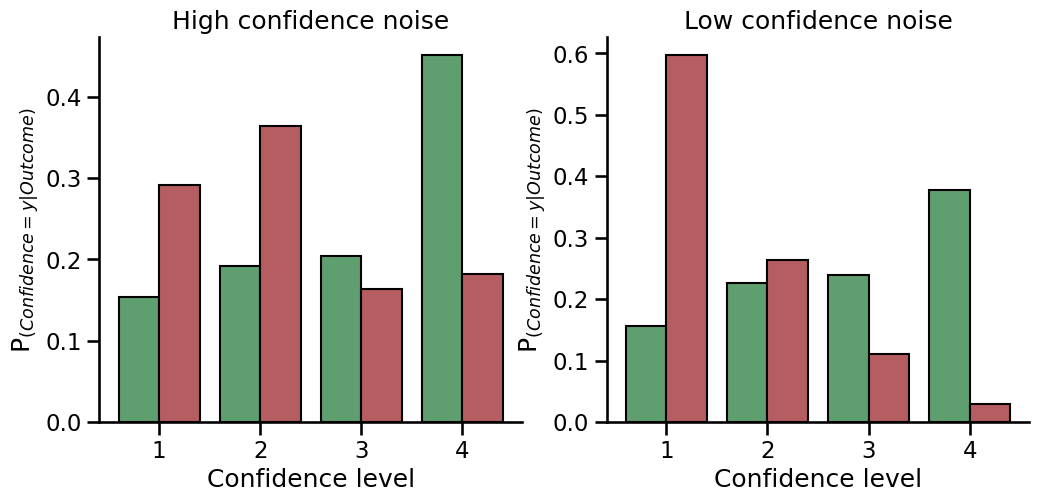

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
for i, data, title in zip(
    [0, 1], [[dHigh_nR_S1, dHigh_nR_S2], [dLow_nR_S1, dLow_nR_S2]], ["High", "Low"]
):
    plot_confidence(nR_S1=data[0], nR_S2=data[1], ax=axs[i])
    axs[i].set_title(f"{title} confidence noise")
sns.despine()

### Now plot the observed type2 data in a type2ROC curve

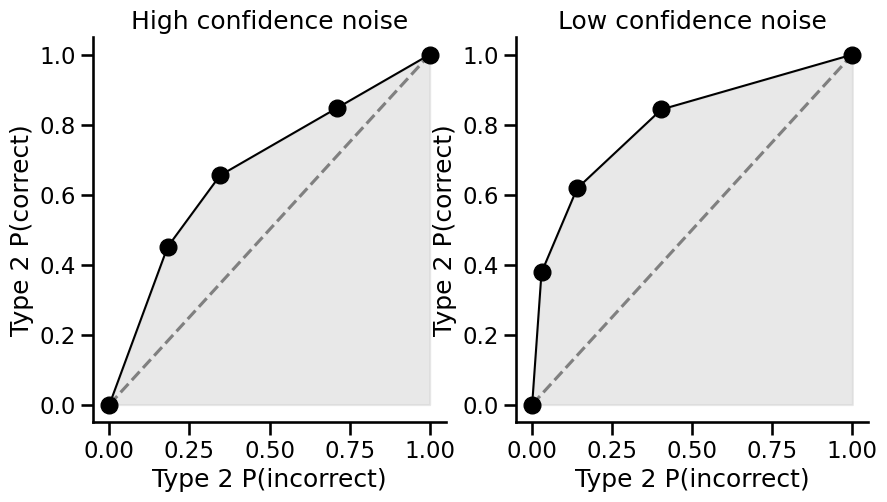

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for i, data, title in zip(
    [0, 1], [[dHigh_nR_S1, dHigh_nR_S2], [dLow_nR_S1, dLow_nR_S2]], ["High", "Low"]
):
    plot_roc(nR_S1=data[0], nR_S2=data[1], ax=axs[i])
    axs[i].set_title(f"{title} confidence noise")
sns.despine()

```{hint}
We can now compare the two types of figures (confidence distributions and type2ROC curves) from the same data to see what the type2ROC curve is plotting. The first point above zero on the curve (second from the left) is the proportion of the correct responses that used the highest confidence rating (i.e. 4 on the confidence scale) plotted against the proportion of incorrect responses that used the highest confidence rating. The next point to the right of this is the proportion of the correct responses that used the highest two confidence ratings (i.e. 3 and 4) against the the proportion of incorrect responses that used the highest two confidence ratings. This continues until we reach 1 in the top right corner of the curve, where we have accounted for all of the correct and incorrect responses across all of the confidence ratings. You can see here that when there is lower confidence noise, the type2ROC curve has a larger 'bow' - it extends closer towards the top left corner of the graph. This is because there is a greater proportion of the correct responses that use the higher confidence ratings, compared to the proportion of the incorrect responses that used the higher ratings. If metacognition was perfect, and a participant only used the higher rating scores when they were correct and the lower rating scores when they were incorrect (and never mixed them), the curve would be a right angle in the top left corner. If metacognition was zero, the curve would be flat and lie on the diagonal dotted line, as there would be approximately the same proportion of correct and incorrect responses no matter what confidence rating was used.
```

Now we will calculate the area under each of the type2ROC curves:

In [6]:
print(f"Low confidence AUC: {roc_auc(nR_S1=dLow_nR_S1, nR_S2=dLow_nR_S2)}")
print(f"High confidence AUC: {roc_auc(nR_S1=dHigh_nR_S1, nR_S2=dHigh_nR_S2)}")

Low confidence AUC: 0.79741039272852
High confidence AUC: 0.670299727520436


```{hint}
Now you should be able to see that the area under the type2ROC curve with lower confidence noise is larger than when the data are produced with higher confidence noise. This metric is often used as an absolute measure of metacognition. 
```

```{Exercise 3}We can also check what happens to the area under the type 2 ROC when we have a higher value of d', and no difference in the confidence noise. To do this, try calculating the area under the type2ROC for the data we simulated using different levels of d' from step 2. How does higher d' affect the area under the typeROC?
```

```{hint}
* You can plot the ROC curve using `metadpy.plotting.plot_roc()`
* You can calculate the area using `metadpy.std.roc_auc()`
```

## Fitting the model: meta-d'

In this step we will consider how we can quantify metacognition using meta-d' rather than the area under a type2ROC curve. Because meta-d' is calculated in the same units as d', we can get rid of the effect of type 1 performance (d') by simply creating a ratio of meta-d' / d', which we call the Mratio. The Mratio is then a 'relative' measure of metacognition, and is independent of task performance. For full details of the model please refer to the paper by {cite:t}`maniscalo:2012`. The key here is actually the direct relationship between type 1 and type 2 performance that we explored in steps 2 and 3, where we can predict what the type2ROC curve *should* look like for a certain type 1 d' and bias (if no information was lost or gained between type 1 and type 2 performance). Therefore, if we take the observed type2ROC curve, we can theoretically estimate what level of d' would cause the observed type 2 performance... And we call this meta-d'! (For details on the relationship between type 1 and type 2 performance, see {cite:t}`galvin:2003`. Here we will plot the observed and estimated confidence values and type2ROC curves for our simulated data with different levels of metacognition, and take a closer look at the model values for meta-d.

**Set up the parameters:**

In [7]:
d = 2  # Set task performance (d')
c = 0  # Set task bias (c)
nTrials = 1000  # Set the number of trials performed
nRatings = 4  # Choose the rating scale to use
metadLow, metadHigh = (
    1,
    2,
)  # This time we will simulate with different values of meta-d'

**Simulate the responses for low and high metacognition:**

In [8]:
low_noise_df = responseSimulation(
    d=d, metad=metadLow, c=c, nRatings=nRatings, nTrials=nTrials
)
high_noise_df = responseSimulation(
    d=d, metad=metadHigh, c=c, nRatings=nRatings, nTrials=nTrials
)

**Now we will fit the model for meta-d':**

**NOTE:** nR_S1 and nR_S2 are the counts of the responses to stimulus 1 (nR_S1) and stimulus 2 (nR_S2) for each confidence level. We can compute this using the function py:func:`metadpy.utils.trials2counts()`.

In [9]:
low_noise_nR_S1, low_noise_nR_S2 = trials2counts(data=low_noise_df, nRatings=nRatings)
high_noise_nR_S1, high_noise_nR_S2 = trials2counts(data=high_noise_df, nRatings=nRatings)

In [10]:
fitLowNoise = fit_metad(low_noise_nR_S1, low_noise_nR_S2, nRatings=nRatings)
fitHighNoise = fit_metad(high_noise_nR_S1, high_noise_nR_S2, nRatings=nRatings)

**Plot the model estimation of type 2 performance with high metacognition:**

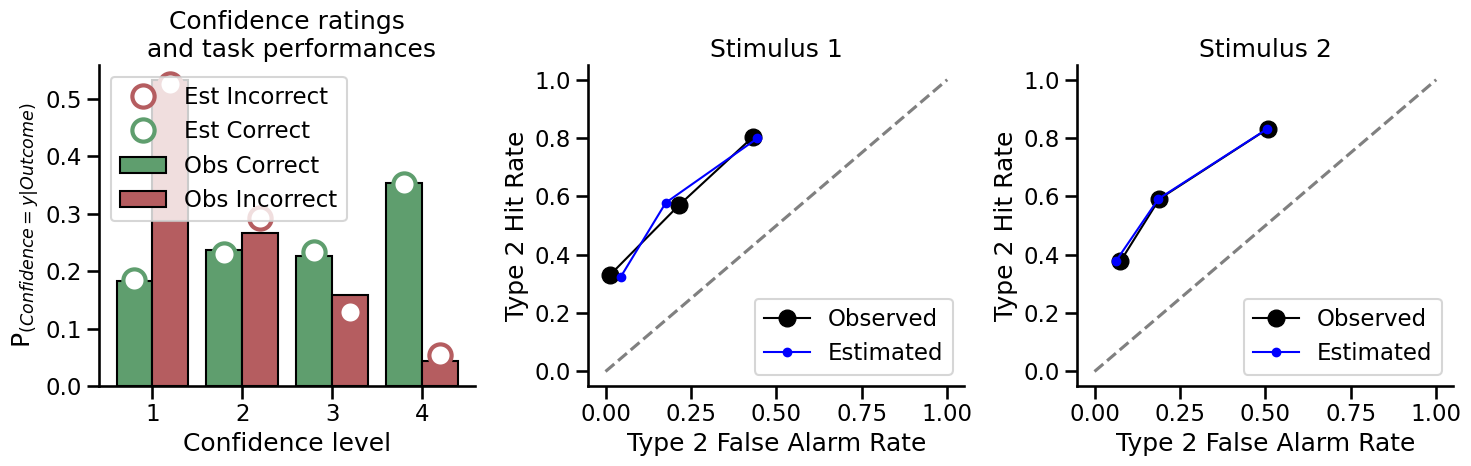

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
plot_confidence(high_noise_nR_S1, high_noise_nR_S2, fitModel=fitHighNoise, ax=ax[0])
plot_roc(high_noise_nR_S1, high_noise_nR_S2, fitModel=fitHighNoise, ax=ax[1:])
plt.tight_layout()
ax[0].legend()
ax[1].legend()
ax[2].legend()
sns.despine()

**Now plot the same figures for the model estimation of type 2 performance with low metacognition:**

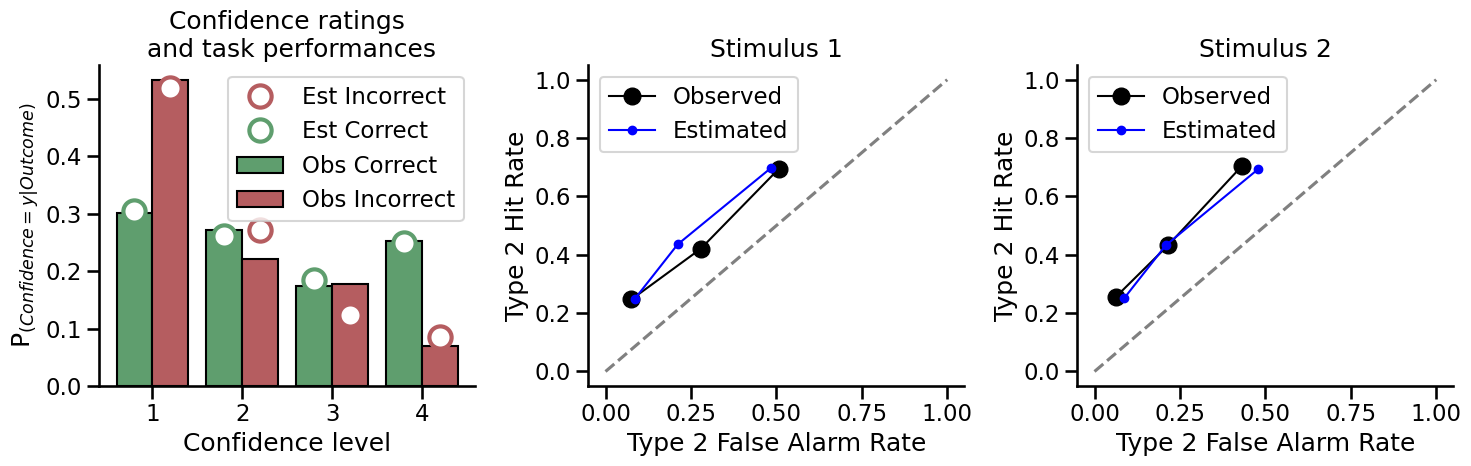

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
plot_confidence(low_noise_nR_S1, low_noise_nR_S2, fitModel=fitLowNoise, ax=ax[0])
plot_roc(low_noise_nR_S1, low_noise_nR_S2, fitModel=fitLowNoise, ax=ax[1:])
plt.tight_layout()
ax[0].legend()
ax[1].legend()
ax[2].legend()
sns.despine()

```{hint}You can see that the model does a pretty good job estimating the confidence values for correct and incorrect responses, and the estimated type2ROC curves are quite close to the observed values (the model estimates the curves for each of the two stimuli separately). We will now explore some extensions to the model that will help us cope with more difficult data.
```

```{Exercise 4}
How do the estimated (fit) Mratio values compare to the simulated Mratio values that we used?
HINT: You can find the fitted Mratio im sim4.highMetad.fit, but you will need to calculate the simulated Mratio.
Next, run this whole section again to simulate new data from the same parameters and re-fit the model. Do you get exactly the same meta-d' and Mratio values as before? Why / why not?
```

## Fitting the model: parameter recovery

We saw in exercise 4 that the meta-d model we are using doesn't give us a perfect estimation of meta-d. We will now take a closer look at how well this model is able to recover meta-d values, using 20 simulations at different levels of meta-d.

### Set up the parameters

In [13]:
d = 2  # Set task performance (d')
d_sigma = 0.1  # Include some between-subject variability
c = 0  # Set task bias (c)
c_sigma = 0.1  # Include some between-subject variability
nTrials = 1000  # Set the number of trials performed
nRatings = 4  # Choose the rating scale to use
nSims = 40  # Specify the number of simulations at each meta-d value
meta_d = [0.5, 1.25, 2.0]  # Specify a range of of meta-d values
meta_d_sigma = 0.1  # Include some between-subject variability

### Simulate the responses and fit the model for different levels of metacognition

In [14]:
results_df = pd.DataFrame([])
for this_meta_d in meta_d:
    for n_trials in [50, 200, 1000]:
        for this_simulation in range(nSims):

            # Generate dprime values
            sim_d = np.random.normal(d, d_sigma)

            # Generate bias values
            sim_c = np.random.normal(c, c_sigma)

            # Generate meta-d values
            sim_meta_d = np.random.normal(this_meta_d, meta_d_sigma)

            # Simulate dataframe of trials
            simulation_df = responseSimulation(
                d=sim_d, metad=sim_meta_d, c=sim_c, nRatings=nRatings, nTrials=n_trials,
            )

            metad_df = metad(data=simulation_df, nRatings=nRatings)

            metad_df["n_simulation"] = this_simulation
            metad_df["true_meta_d"] = this_meta_d
            metad_df["n_trials"] = n_trials

            # Store results
            results_df = pd.concat([results_df, metad_df])

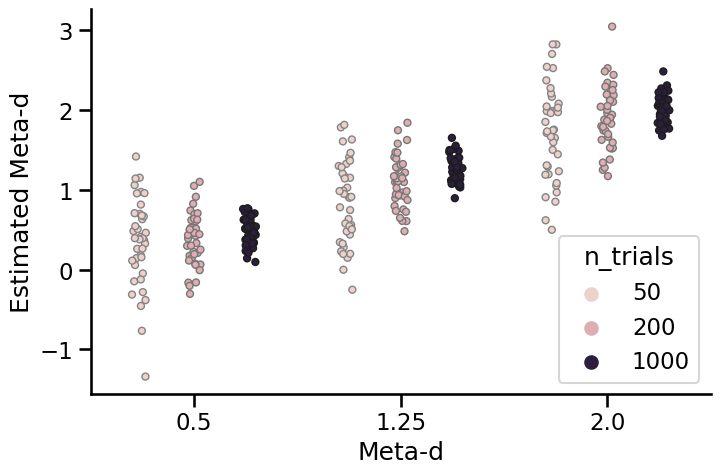

In [15]:
plt.figure(figsize=(8, 5))
sns.stripplot(
    data=results_df, x="true_meta_d", y="meta_d", hue="n_trials", linewidth=1, dodge=True
    )
plt.xlabel("Meta-d")
plt.ylabel("Estimated Meta-d")
sns.despine()

```{hint}
Here we can see that there is some variance in the model fits for each value of meta-d', even when the data were generated from the same underlying parameters. However, they are centred around the generated value, and do not appear to be biased towards being too high or too low.
```

```{Exercise 5}
Drop the trial numbers (Ntrials) per simulation down to just 100, and re-run the simulation and recovery procedure you just performed. What happens to the recovered values of meta-d with lower numbers of trials per subject? Do you think this may or may not be a problem? Feel free to try other trial numbers if you are interested.
```